(https://www.kaggle.com/c/ashrae-energy-prediction/)

# ASRAE - Modeling

In [58]:
import numpy as np
import pandas as pd

import seaborn as sns
import plotly as plt
import plotly.express as px
import plotly.figure_factory as ff
import matplotlib.pyplot as plt

from math import sqrt

import glob

import pandas_profiling as ppf
import sweetviz as sv
import missingno as msno

import pprint
import datetime
from math import sqrt

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, median_absolute_error

from prophet import Prophet

import xgboost as xgb

import pmdarima as pm
from pmdarima import model_selection
from pmdarima import pipeline
from pmdarima import preprocessing as ppc
from pmdarima import arima
from pmdarima.arima import ndiffs
from pmdarima.arima import ADFTest

print("pmdarima version: %s" % pm.__version__)

#import tools as tl

sns.set(rc={'figure.figsize':(30,20)})

pd.options.display.float_format = '{:.2f}'.format
pd.set_option("precision", 2)

plt.rcParams.update({'font.size': 22})
sns.set(font_scale = 2)

import pprint
pp = pprint.PrettyPrinter(indent=4)

import warnings
warnings.filterwarnings('ignore')

pmdarima version: 1.8.2


In [59]:
print(xgb.__version__)

1.4.2


In [60]:
pd.options.plotting.backend = "matplotlib"

In [61]:
pwd

'G:\\My Drive\\Code\\Springboard_Capstone_Energy'

In [62]:
# Drop Specific columns
def building_meter_drop(df):
    return df.drop(columns=['precip_depth_1_hr','wind_direction','wind_speed','dew_temperature','year_built','floor_count','cloud_coverage'],axis=1)

In [63]:
# Interpolate Missing Data
def building_meter_interp(df):
    df['sea_level_pressure'] = df['sea_level_pressure'].interpolate(method='time')
    df['meter_reading'] = df['meter_reading'].interpolate(method='time')
    df['air_temperature'] = df['air_temperature'].interpolate(method='time')
    return df

In [64]:
# Aggregate remaining Data
def building_meter_agg(df,resamp_str):
    df_samp = df
    agg_dict={'meter_reading':'median', 
              'air_temperature':'median',
                  'building_id': 'max',
                  'site_id': 'max',
                  'square_feet': 'max',
                  'day_of_week':'max',
                  'weekend':'max',
                  'month':'max',
                  'season':'max'
                  }

    # Resample Dataframe
    df = df.resample(resamp_str).agg(agg_dict)
    
    return df

## See Statistics written for each file (building-meter) combo

In [65]:
# See Building Statistics for missing data
df_stats = pd.read_csv('.//data_clean//building_reading_stats.csv')
# Keep only data that has at least 50 % of it

In [66]:
df_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2375 entries, 0 to 2374
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   file_name                     2375 non-null   object 
 1   building                      2375 non-null   int64  
 2   meter                         2375 non-null   int64  
 3   len_train                     2375 non-null   int64  
 4   len_zero                      2375 non-null   int64  
 5   per_data                      2375 non-null   float64
 6   category                      2375 non-null   object 
 7   corr_meter_to_airtemp         2375 non-null   float64
 8   corr_meter_to_airtemp_wknd    2373 non-null   float64
 9   corr_meter_to_airtemp_wkdy    2375 non-null   float64
 10  corr_meter_to_airtemp_winter  2325 non-null   float64
 11  corr_meter_to_airtemp_spring  2342 non-null   float64
 12  corr_meter_to_airtemp_summer  2339 non-null   float64
 13  cor

In [67]:
# Modeling Choices
# Buildings with 1
df_stats.sort_values(['building','meter'],axis=0,inplace=True)
df_stats.reset_index(drop=True,inplace=True)

In [68]:
df_stats[(df_stats['building'] == 1148) & df_stats['meter'] == 1]

,file_name,building,meter,len_train,len_zero,per_data,category,corr_meter_to_airtemp,corr_meter_to_airtemp_wknd,corr_meter_to_airtemp_wkdy,corr_meter_to_airtemp_winter,corr_meter_to_airtemp_spring,corr_meter_to_airtemp_summer,corr_meter_to_airtemp_fall,square_feet,site_id,floor_count,bldg_size,meter_name
1686,1148_1.pkl,1148,1,8784,0,100.00,Office,0.78,0.79,0.79,0.21,0.74,0.45,0.76,861524,13,-1,XXL,CWater


In [69]:
# Examine building choices
df_stats[df_stats['building'] == 1148]

,file_name,building,meter,len_train,len_zero,per_data,category,corr_meter_to_airtemp,corr_meter_to_airtemp_wknd,corr_meter_to_airtemp_wkdy,corr_meter_to_airtemp_winter,corr_meter_to_airtemp_spring,corr_meter_to_airtemp_summer,corr_meter_to_airtemp_fall,square_feet,site_id,floor_count,bldg_size,meter_name
1685,1148_0.pkl,1148,0,8663,0,100.00,Office,-0.02,0.15,-0.04,-0.20,-0.11,-0.08,-0.08,861524,13,-1,XXL,Elec
1686,1148_1.pkl,1148,1,8784,0,100.00,Office,0.78,0.79,0.79,0.21,0.74,0.45,0.76,861524,13,-1,XXL,CWater
1687,1148_2.pkl,1148,2,8784,2,99.98,Office,-0.88,-0.86,-0.88,-0.83,-0.85,-0.43,-0.44,861524,13,-1,XXL,Steam


# First Pass 
## No Hypertuning on Prophet or XGBoost

In [31]:
## Train till end of September, Test on October


###########################################################
File: 107_0.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model......
Median Percent Error of Range: 23.529196408671943


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... Median Percent Error of Range: 215.86855848279095

XGBoost...... Median Percent Error of Range: 31.83852589198522


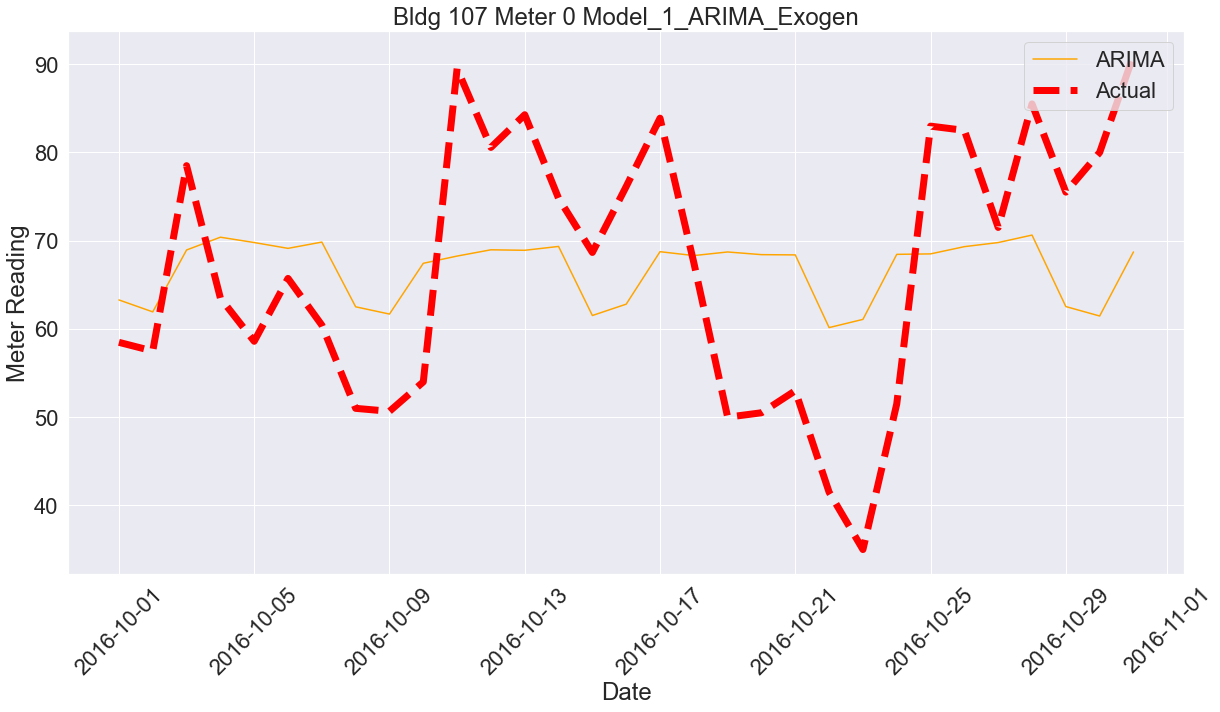

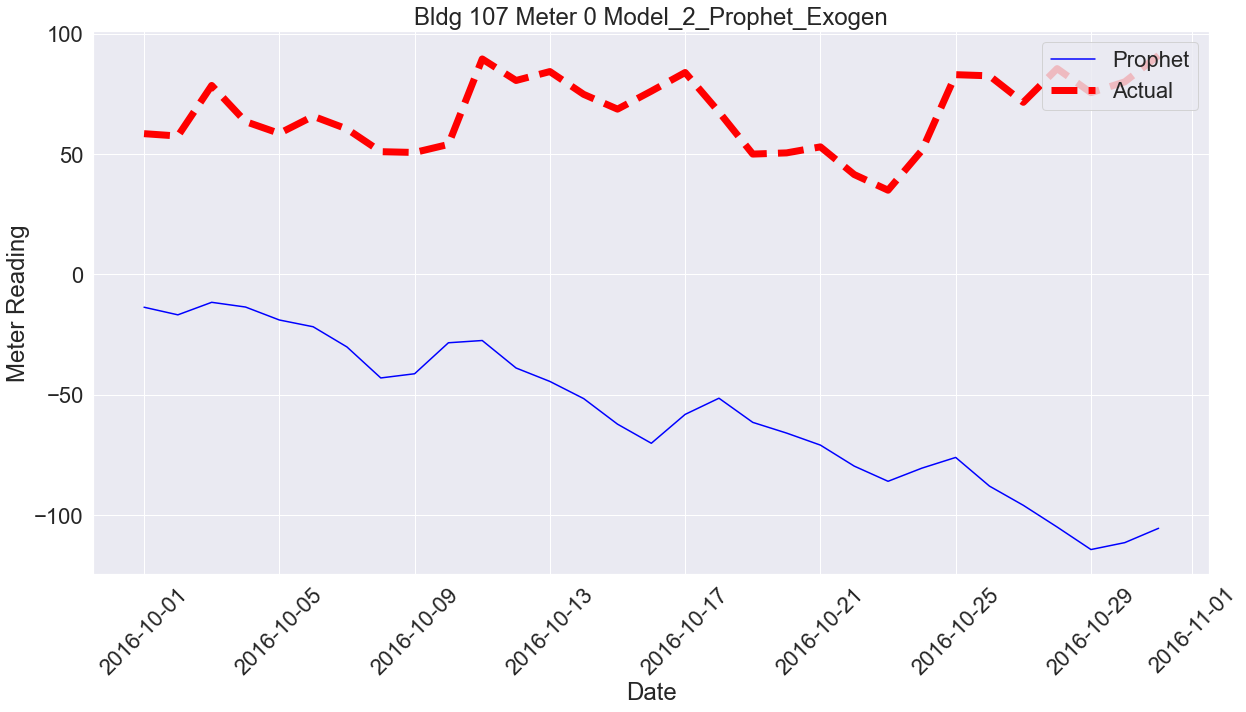

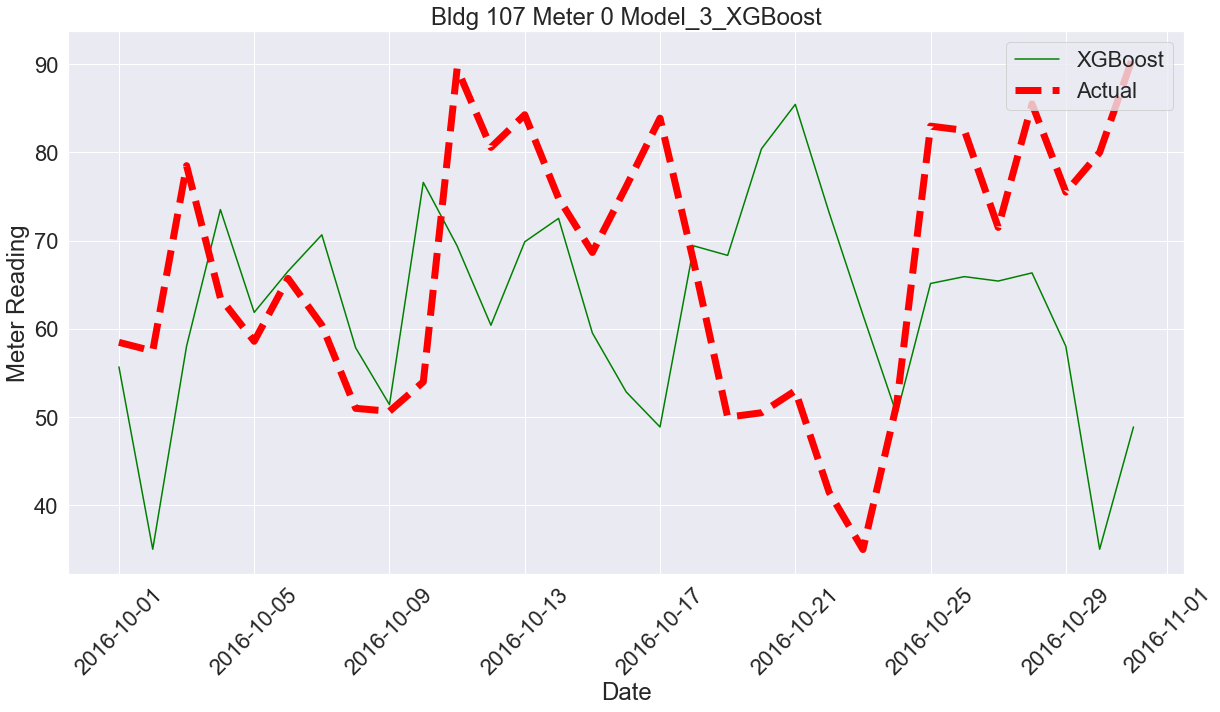

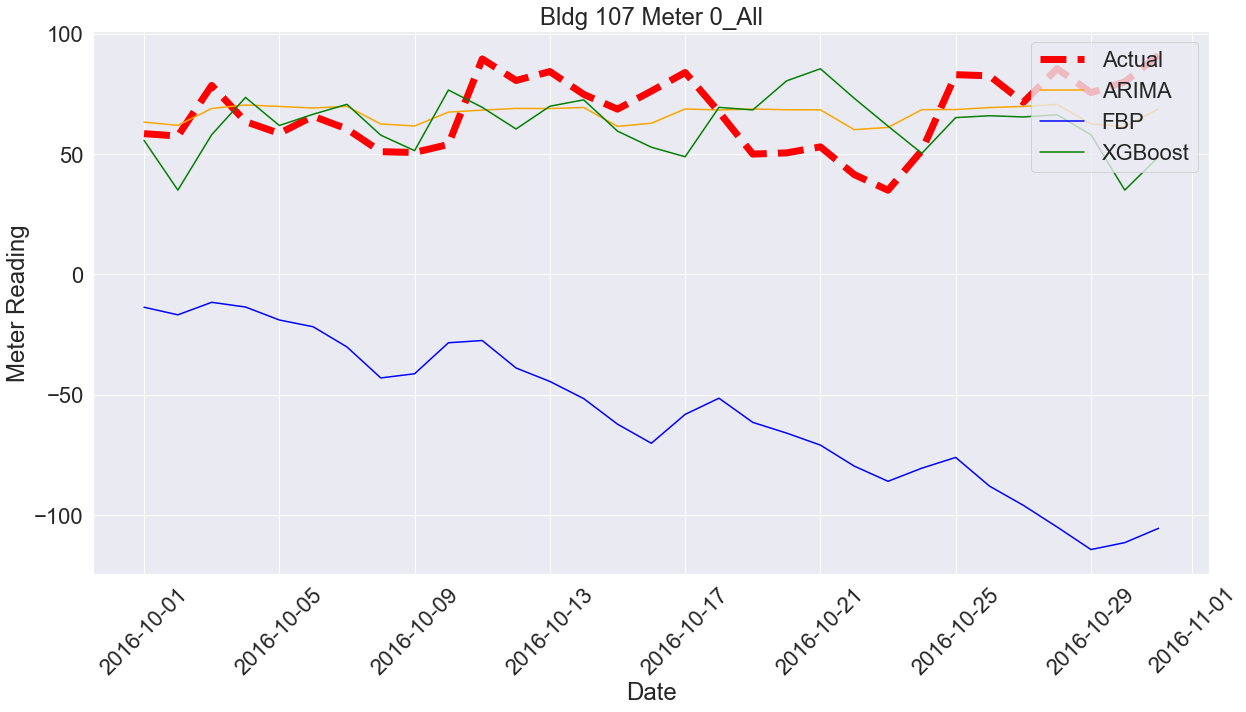

In [79]:

output_vis_folder = '.\\visualization\\models\\run_1\\'
output_data_folder = '.\\results\\'

model_pass = 1

# Control Variables that will run these specific models if True
ARIMA = True
FBProphet = True
xgboost = True

# Show Visualizations
quiet_mode = True

resample = True
backfill = 'mean'
exogen = True

thresh = 50

# Dictionary to hold all the results, will turn into a dataframe
stats_all = {}
stats_list = []

stats = {}

# For each file in the directory
direct = '.\\data_clean\\buildings_by_meter\\'

files = df_stats['file_name']

bld_mtr = [
#            '1073_2', # Elec
#             '1073_1',
#             '1073_0',
# #             '1099_2', # Education 
#             '1130_0',
#             '1048_0',
#             '1156_0',
#             '1156_2',
#             '1140_1',
#             '1169_1',
#             '1178_0',
            '107_0',
#             '1180_2',
#             '119_0',
#             '1198_2',
#             '120_0',
#             '109_0',
#             '1138_0',
#             '1079_2',
#             '126_0',
#             '1179_1', # Entertainment
#             '1183_0',
#             '1196_0',
#             '743_0',
#             '663_0', # Food
#             '1105_0',
#             '1105_2',
#             '670_0',
#             '1209_2',
#             '1154_2', # Lodging Residential
#             '1154_0',
#             '134_0',
#             '1184_0',
#             '135_0',
#             '1124_0',
#             '1091_0'
#             '1175_0', # Manufacturing
#             '1171_0',
#             '1081_0',
#             '1145_2',
#             '1148_1', # Office
#             '1164_1',
#             '1151_1',
#             '1149_0',
#             '1188_0',
#             '141_0',
#             '146_0',
#             '1204_2',
#             '1210_1',
#             '1133_2',
#             '155_0',
#             '1164_1',
#             '1109_2',
#             '684_0',
#             '1108_0',
#             '1205_0',
#             '1212_1',
#             '1220_0',
#             '1047_0',
#             '678_0',
#             '1104_0'
#             '1052_2',
#             '1034_0',
#             '1197_0',
#             '1118_0',
#             '1199_0'
          ]

for num,file in enumerate(files):  

    # Get only files from the list
    if file.split('.pkl')[0] not in bld_mtr:
        continue
    else:
        print('')
        print('###########################################################')
        print('File: ' + file)
        
    # Temporary dictionary that represents raw calculations
    stats = {}
    
    # Screen results
    if df_stats.iloc[num]['per_data'] < 80:
        stats['status'] = 'FAIL: Length < 80% data present'
        print('not enough data')
        continue
    
    # Catch exception if file not readable
    try:
        df = pd.read_pickle(direct + file)
    except FileNotFoundError:
        continue
    
    print('Length on load: ' + str(len(df)))
    stats['Len_load'] = len(df)
    
    # Screen minimum length
    if len(df) < 20000:
        stats['status'] = 'FAIL: Length < 20k'
        continue

    # Load key variables in dictionary
    stats['building'] = df.iloc[0]['building_id']
    stats['square_feet'] = df.iloc[0]['square_feet']   
    stats['meter'] = bldg_meter = df.iloc[0]['meter']
    stats['file_name'] = file
 
    # Process Columns
    df = building_meter_drop(df) # Drop poorly correlated columns
    df = building_meter_interp(df) # Time series linear interpolation due to standard time deltas
    df = building_meter_agg(df,'1D') # aggregate remaining columns
    
    print('Length after agg: ' + str(len(df)))
    stats['Len_agg-clean'] = len(df)
    
    # Find out how many lingering NA columns are left
    b4_NA = len(df)
    df.dropna(how='any',inplace=True)
    tot = b4_NA - len(df)
    print('Dropped N/A cols: ' + str(tot))
    if tot > 100:
        stats['status'] = 'FAIL: Drop over 100 Rows'
        continue
    
    print('Length after blank drop: ' + str(len(df)))
    stats['Len_blank'] = len(df)
    
    # Keep track of Models
    model_ctr = 1 # Initialize Model Counter
    model_prefixes = []


    df_train = df.loc['2016-01-01':'2016-09-30']
    df_test = df.loc['2016-10-01':'2016-10-31']
       
    X_train = df_train.drop(labels=['meter_reading'],axis=1)
    X_train.fillna(method='ffill')

    X_test = df_test.drop(labels=['meter_reading'],axis=1)
    X_test.fillna(method='ffill')

    y_train = df_train['meter_reading']
    y_train.fillna(method='ffill')

    y_test = df_test['meter_reading']
    y_test.fillna(method='ffill')
    
    # Get rid of constants
    X_train.drop(labels=['site_id','building_id','square_feet'],axis=1,inplace=True)
    X_test.drop(labels=['site_id','building_id','square_feet'],axis=1,inplace=True)
    
    #######################################    ARIMA   ##################################################
    if ARIMA:
        print()
        # Keep track of model prefix column names by building prefix to number iterations
        model_prefix = 'Model_' + str(model_ctr)
        model_prefixes.append(model_prefix)
        # Populate DataFrame with statistics
        stats[model_prefix + '_' + 'Type'] = 'ARIMA_Exogen'
        stats[model_prefix + '_' + 'Description'] = 'ARIMA_Exogen, with daily aggregation'
        stats[model_prefix + '_' + 'Len_Train'] = len(X_train)
        stats[model_prefix + '_' + 'Len_Test'] = len(X_test)

        print('ARIMA Model......')

        # Try building model
        try:
            model = pm.auto_arima(y_train,X=X_train,trace=False,n_fits=10,seasonal=True,m=7,error_action='ignore')
            stats[model_prefix + '_' + 'Status'] = 'PASS'
        except ValueError as ve:
            print('Model will not converge')
            stats[model_prefix + '_' + 'Status'] = 'FAIL'
            continue

        # Create the Series
        preds, conf_int = model.predict(X=X_test,n_periods=y_test.shape[0], return_conf_int=True)
                
        predict = pd.Series(preds,index=y_test.index)

        # Keep each slice data here
        df_result = pd.concat([predict,y_test],axis=1)
        df_result.columns = ['meter_predict_ARIMA','meter_actual']

        # Error Calculations ------------------------
        # RMSE
        RMSE_error = (mean_squared_error(df_result['meter_predict_ARIMA'],df_result['meter_actual'],squared=False))
        stats[model_prefix + '_' + 'RMSE'] = RMSE_error
        
        # RMSE relative to the range of the test range
        RMSE_pct_range = RMSE_error / ((np.max(df_result['meter_actual'])) \
                                       - (np.min(df_result['meter_actual']))) \
                                       * 100      
        stats[model_prefix + '_' + 'y_pred_RMSE_pct_Range'] = RMSE_pct_range
        
        # MAPE
        MAPE_error = mean_absolute_percentage_error(df_result['meter_predict_ARIMA'],df_result['meter_actual'])
        stats[model_prefix + '_' + 'MAPE'] = MAPE_error
        
        # Median Absolute Percentage
        MedAPE_error = median_absolute_error(df_result['meter_predict_ARIMA'],df_result['meter_actual'])
        stats[model_prefix + '_' + 'MedianAPE'] = MedAPE_error
        
        MedAPE_pct_range = MedAPE_error / ((np.max(df_result['meter_actual'])) \
                                       - (np.min(df_result['meter_actual']))) \
                                       * 100  
        stats[model_prefix + '_' + 'Median_Pct_Error_Range'] = MedAPE_pct_range

#         print('RMSE: ' + str(RMSE_error)) 
#         print('RMSE_pct_range: ' + str(RMSE_pct_range))
#         print('MAPE: ' + str(MAPE_error))
#         print('MedianAPE: ' + str(MedAPE_error))
        print('Median Percent Error of Range: ' + str(MedAPE_pct_range))
            
        # Create Graph
        plt.ioff()
        plt.figure(figsize=(20,10))
        plt.plot(df_result['meter_predict_ARIMA'],label="ARIMA", color='orange', linestyle='solid')
        plt.plot(df_result['meter_actual'],label="Actual",linewidth=7.0, color='red', linestyle='dashed')
        plt.legend(loc = 'upper right')      
        plt.title('Bldg ' + str(stats['building']) + ' Meter ' + str(stats['meter']) + ' ' + model_prefix + '_' + 'ARIMA_Exogen')
        plt.xlabel('Date')
        plt.ylabel('Meter Reading')
        plt.xticks(rotation='45')
        plt.savefig(output_vis_folder + str(stats['building']) + '_' + str(stats['meter']) + '_ARIMA_Exogen.jpg')
        
        # Add to Models DF
        df_models = pd.DataFrame(data=df_result[['meter_actual','meter_predict_ARIMA']],index=df_result.index)
          
         ######################################    PROPHET   ##################################################
    if FBProphet:   
        print()
        print('Prophet......',end=' ')
        model_ctr += 1 # Increment Model Counter
        model_prefix = 'Model_' + str(model_ctr) # Build string for keys
        model_prefixes.append(model_prefix)

        # Need renaming for Prophet - data prep
        df_prophet_train = df_train.reset_index()
        df_prophet_test = df_test.reset_index()

        # Get rid of constants
        df_prophet_train.drop(labels=['site_id','building_id','square_feet'],axis=1,inplace=True)
        df_prophet_test.drop(labels=['site_id','building_id','square_feet'],axis=1,inplace=True)

        # Timestamp must be ds column
        df_prophet_train = df_prophet_train.rename(columns={'timestamp':'ds','meter_reading':'y'})
        df_prophet_test = df_prophet_test.rename(columns={'timestamp':'ds','meter_reading':'y'})


        # Populate DataFrame with statistics
        stats[model_prefix + '_' + 'Type'] = 'Prophet_Exogen'          
        stats[model_prefix + '_' + 'Len_Train'] = len(df_prophet_train)
        stats[model_prefix + '_' + 'Len_Test'] = len(df_prophet_test)

        # Initialize Prophet Model
        m = Prophet(daily_seasonality=True)
        m.add_regressor('air_temperature')
        m.add_regressor('day_of_week')
        m.add_regressor('weekend')
        m.add_regressor('month')
        m.add_regressor('season')
        m.fit(df_prophet_train)
        predicts = m.predict(df_prophet_test)


        # Error Calculations ------------------------
        # RMSE
        RMSE_error = (mean_squared_error(predicts['yhat'],df_prophet_test['y'],squared=False))
        stats[model_prefix + '_' + 'RMSE'] = RMSE_error

        # RMSE relative to the range of the test range
        RMSE_pct_range = RMSE_error / ((np.max(df_prophet_test['y'])) \
                                              - (np.min(df_prophet_test['y']))) \
                                              * 100   
        stats[model_prefix + '_' + 'y_pred_RMSE_pct_Range'] = RMSE_pct_range

        # MAPE
        MAPE_error = mean_absolute_percentage_error(predicts['yhat'],df_prophet_test['y'])
        stats[model_prefix + '_' + 'MAPE'] = MAPE_error

        # Median Absolute Percentage
        MedAPE_error = median_absolute_error(predicts['yhat'],df_prophet_test['y'])
        stats[model_prefix + '_' + 'MedianAPE'] = MedAPE_error


        MedAPE_pct_range = MedAPE_error / ((np.max(df_prophet_test['y'])) \
                                              - (np.min(df_prophet_test['y']))) \
                                              * 100 

        stats[model_prefix + '_' + 'y_pred_MedAPE_pct_Range'] = MedAPE_pct_range

#         print('RMSE: ' + str(RMSE_error)) 
#         print('RMSE_pct_range: ' + str(RMSE_pct_range))
#         print('MAPE: ' + str(MAPE_error))
#         print('MedianAPE: ' + str(MedAPE_error))
        print('Median Percent Error of Range: ' + str(MedAPE_pct_range))

        plt.ioff()
        plt.figure(figsize=(20,10))
        plt.plot(df_prophet_test['ds'],predicts['yhat'],label="Prophet", color='blue', linestyle='solid')
        plt.plot(df_prophet_test['ds'],df_prophet_test['y'],label="Actual",linewidth=7.0,color='red',linestyle='dashed')
        plt.legend(loc = 'upper right')
        plt.title('Bldg ' + str(stats['building']) + ' Meter ' + str(stats['meter']) + ' ' + \
                  model_prefix + '_' + 'Prophet_Exogen')
        plt.xlabel('Date')
        plt.ylabel('Meter Reading')
        plt.xticks(rotation='45')

        plt.savefig(output_vis_folder + str(stats['building']) + '_' + str(stats['meter']) + '_Prophet_Exogen.jpg')
        
        df_models['meter_predict_Prophet'] = pd.Series(predicts['yhat'].values, index=df_models.index)

#       ######################################    XGBOOST   ##################################################
    if xgboost:
        print()
        print('XGBoost......',end=' ')
        model_ctr += 1
        model_prefix = 'Model_' + str(model_ctr)
        model_prefixes.append(model_prefix)

        # Populate DataFrame with statistics
        stats[model_prefix + '_' + 'Type'] = 'XGBoost'
        stats[model_prefix + '_' + 'Description'] = 'XGBoost_Exogen, with daily aggregation'
        stats[model_prefix + '_' + 'Len_Train'] = len(X_train)
        stats[model_prefix + '_' + 'Len_Test'] = len(X_test)

        # Instantiate Model
        gbm_model = xgb.XGBRegressor(objective = 'reg:squarederror', n_estimators = 1000, seed = 123)
        gbm_model.fit(X_train,y_train)
        predict = gbm_model.predict(X_test)

        predict = pd.Series(predict,index=y_test.index)

        df_result = pd.concat([predict,y_test],axis=1,ignore_index=True)
        df_result.columns = ['meter_predict_XGBoost','meter_actual']
        df_result.sort_index(inplace=True)             

        # Error Calculations ------------------------
        # RMSE
        RMSE_error = (mean_squared_error(df_result['meter_predict_XGBoost'],df_result['meter_actual'],squared=False))
        stats[model_prefix + '_' + 'RMSE'] = RMSE_error

        # RMSE relative to the range of the test range
        RMSE_pct_range = RMSE_error / ((np.max(df_result['meter_actual'])) \
                                       - (np.min(df_result['meter_actual']))) \
                                       * 100      
        stats[model_prefix + '_' + 'y_pred_RMSE_pct_Range'] = RMSE_pct_range

        # MAPE
        MAPE_error = mean_absolute_percentage_error(df_result['meter_predict_XGBoost'],df_result['meter_actual'])
        stats[model_prefix + '_' + 'MAPE'] = MAPE_error

               # Median Absolute Percentage
        MedAPE_error = median_absolute_error(df_result['meter_predict_XGBoost'],df_result['meter_actual'])
        stats[model_prefix + '_' + 'MedianAPE'] = MedAPE_error

        MedAPE_pct_range = MedAPE_error / ((np.max(df_result['meter_actual'])) \
                               - (np.min(df_result['meter_actual']))) \
                               * 100  
        stats[model_prefix + '_' + 'y_pred_MedAPE_pct_Range'] = MedAPE_pct_range

#         print('RMSE: ' + str(RMSE_error)) 
#         print('RMSE_pct_range: ' + str(RMSE_pct_range))
#         print('MAPE: ' + str(MAPE_error))
#         print('MedianAPE: ' + str(MedAPE_error))
        print('Median Percent Error of Range: ' + str(MedAPE_pct_range))

        plt.ioff()
        plt.figure(figsize=(20,10))
        plt.plot(df_result['meter_predict_XGBoost'],label="XGBoost",color='green',linestyle='solid')
        plt.plot(df_result['meter_actual'],label="Actual",linewidth=7.0, color='red',linestyle='dashed')
        plt.legend(loc = 'upper right')
        plt.title('Bldg ' + str(stats['building']) + ' Meter ' + str(stats['meter']) + ' ' + model_prefix + '_' + 'XGBoost')
        plt.xlabel('Date')
        plt.ylabel('Meter Reading')
        plt.xticks(rotation='45')
        plt.savefig(output_vis_folder + str(stats['building']) + '_' + str(stats['meter']) + '_XGBoost.jpg')

        # Apppend to Models Dataframe
        df_models = pd.concat([df_models,df_result['meter_predict_XGBoost']],axis=1)
        df_models.to_csv(output_data_folder + str(stats['building']) + '_' + str(stats['meter']) + '_ModelError_1.csv',float_format="{:,.2f}".format)
        
    
    # VISUALIZE ALL MODELS AT ONCE
    plt.figure(figsize=(20,10))
    plt.plot(df_models['meter_actual'],label='Actual',linewidth=7.0,color='red',linestyle='dashed')
    plt.plot(df_models['meter_predict_ARIMA'],label='ARIMA',color='orange',linestyle='solid')
    plt.plot(df_models['meter_predict_Prophet'],label='FBP',color='blue',linestyle='solid')
    plt.plot(df_models['meter_predict_XGBoost'],label='XGBoost',color='green',linestyle='solid')
    plt.legend(loc = 'upper right')
    plt.title('Bldg ' + str(stats['building']) + ' Meter ' + str(stats['meter']) + '_' + 'All')
    plt.xlabel('Date')
    plt.ylabel('Meter Reading')
    plt.xticks(rotation='45')
    plt.savefig(output_vis_folder + str(stats['building']) + '_' + str(stats['meter']) + '_ALL.jpg')
    
    
    stats_list.append(stats)
    # Write dictionary and file every 10 buildings to save results
    if stats['building'] % 10 == 0:
#         df_results = pd.DataFrame(stats_list)
        df_results.to_csv(output_data_folder + 'Model_Results_1.csv',float_format="{:,.2f}".format)
            
df_results = pd.DataFrame(stats_list)
# df_results.to_csv(output_data_folder + 'Model_Results_FirstPass.csv',float_format="{:,.2f}".format)
df_stats = df_results.merge(df_stats,how='left',on=['file_name'])
df_stats.to_csv(output_data_folder + 'AllResults_FirstPass.csv',float_format="{:,.2f}".format)


# Second Pass
## Hyperparameter Tuning on Prophet and XGBoost

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



###########################################################
File: 107_0.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

Prophet...... Tuning Prophet....
Tuning Iteration: 0


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 1


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 2


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 3


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 4


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 5


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 6


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 7
Median Percent Error of Range: 23.795165825276854
Best Parameters: 
{'seasonality_mode': 'additive', 'n_changepoints': 100, 'changepoint_prior_scale': 0.5}
XGBoost......
Median Percent Error of Range: 32.31306076049805


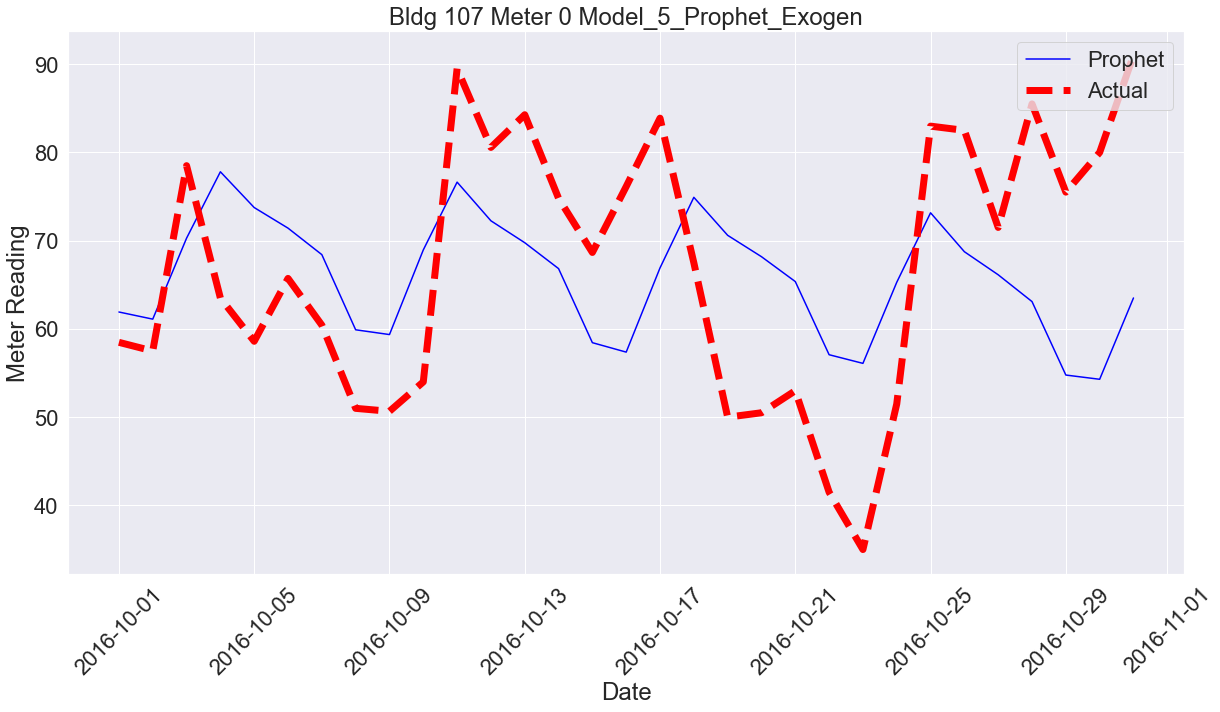

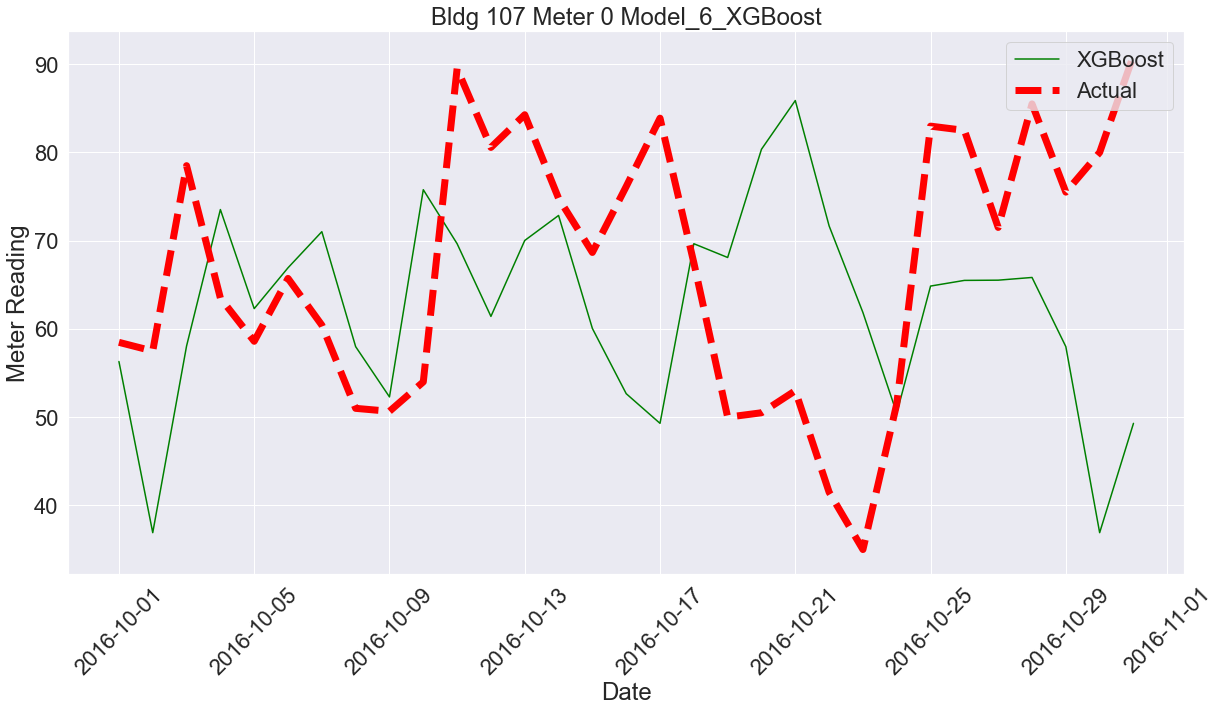

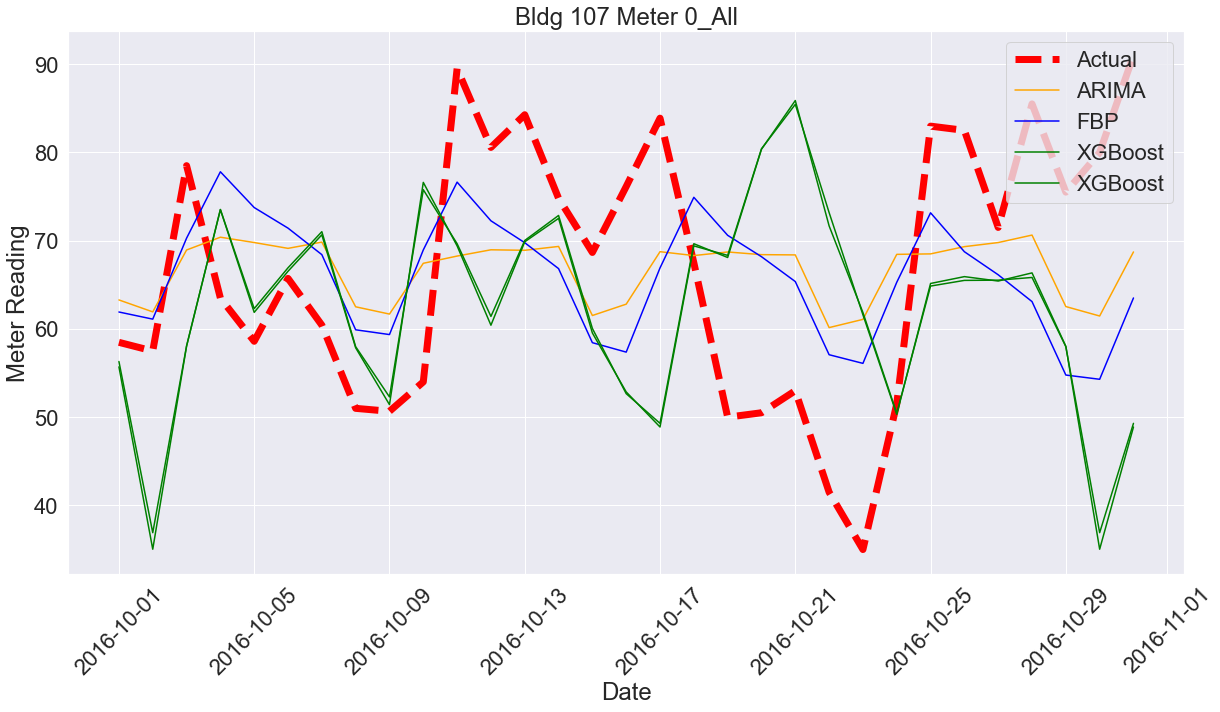

In [80]:
# Data is daily
# # data_sizes = [360] # Start with one year # Train on whole year
output_vis_folder = '.\\visualization\\models\\run_2\\'
output_data_folder = '.\\results\\'

# Median Average Percentage of Range
# tune_on = 'RMSE'
# tune_on = 'RMSEpctRange'
# tune_on = 'MAPE'
# tune_on = 'MedAE'
tune_on = 'MedAEpctRange'

model_pass = 2

# Control Variables that will run these specific models if True
ARIMA = False
FBProphet = True
xgboost = True

# Show Visualizations
quiet_mode = True

resample = True
backfill = 'mean'
exogen = True

thresh = 50

# Dictionary to hold all the results, will turn into a dataframe
stats_all = {}
stats_list = []

stats = {}

# For each file in the directory
direct = '.\\data_clean\\buildings_by_meter\\'

files = df_stats['file_name']
# bl = df_stats['building']

bld_mtr = [#'1073_2', # Elec
           #'1073_1',
           #'1073_0',
#            '1099_2', # issues 
#            '1130_0',
#            '1048_0',
#            '1156_0',
#            '1156_2',
#            '1140_1',
#            '1169_1',
#            '1178_0',
           '107_0',
#            '1180_2',
#            '119_0',
#            '1198_2',
#            '120_0',
#            '109_0',
#            '1138_0',
#            '1079_2',
#            '126_0',
#            '1179_1', # Entertainment
#            '1183_0',
#            '1196_0',
#            '743_0',
#            '663_0', # Food
#            '1105_0',
#            '1105_2',
#            '670_0',
#            '1209_2',
#            '1154_2', # Lodging Residential
#            '1154_0',
#            '134_0',
#            '1184_0',
#            '135_0',
#            '1124_0',
#            '1091_0'
#            '1175_0', # Manufacturing
#            '1171_0',
#            '1081_0',
#            '1145_2',
#            '1148_1', # Office
#            '1164_1',
#            '1151_1',
#            '1149_0',
#            '1188_0',
#            '141_0',
#            '146_0',
#            '1204_2',
#            '1210_1',
#            '1133_2',
#            '155_0',
#            '1164_1',
#            '1109_2',
#            '684_0',
#            '1108_0',
#            '1205_0',
#            '1212_1',
#            '1220_0',
#            '1047_0',
#            '678_0',
#            '1104_0'
#            '1052_2',
#            '1034_0',
#            '1197_0',
#            '1118_0',
#            '1199_0'
          ]

for num,file in enumerate(files):  
    # Get only files from the list
    if file.split('.pkl')[0] not in bld_mtr:
        continue
    else:
        print('')
        print('###########################################################')
        print('File: ' + file)
        
    # Temporary dictionary that represents raw calculations
    stats = {}
    
    # Screen results
    if df_stats.iloc[num]['per_data'] < 80:
        stats['status'] = 'FAIL: Length < 80% data present'
        print('not enough data')
        continue
    
    # Catch exception if file not readable
    try:
        df = pd.read_pickle(direct + file)
    except FileNotFoundError:
        continue
    
    print('Length on load: ' + str(len(df)))
    stats['Len_load'] = len(df)
    
    # Screen minimum length
    if len(df) < 20000:
        stats['status'] = 'FAIL: Length < 20k'
        continue

    # Load key variables in dictionary
    stats['building'] = df.iloc[0]['building_id']
    stats['square_feet'] = df.iloc[0]['square_feet']   
    stats['meter'] = bldg_meter = df.iloc[0]['meter']
    stats['file_name'] = file
 
    # Process Columns
    df = building_meter_drop(df) # Drop poorly correlated columns
    df = building_meter_interp(df) # Time series linear interpolation due to standard time deltas
    df = building_meter_agg(df,'1D') # aggregate remaining columns
    
    print('Length after agg: ' + str(len(df)))
    stats['Len_agg-clean'] = len(df)
    
    # Find out how many lingering NA columns are left
    b4_NA = len(df)
    df.dropna(how='any',inplace=True)
    tot = b4_NA - len(df)
    print('Dropped N/A cols: ' + str(tot))
    if tot > 100:
        stats['status'] = 'FAIL: Drop over 100 Rows'
        continue
    
    print('Length after blank drop: ' + str(len(df)))
    stats['Len_blank'] = len(df)
    
    # Keep track of Models
    model_ctr = 4 # Initialize Model Counter
    model_prefixes = []
  
    df_train = df.loc['2016-01-01':'2016-09-30']
    df_test = df.loc['2016-10-01':'2016-10-31']
       
    X_train = df_train.drop(labels=['meter_reading'],axis=1)
    X_train.fillna(method='ffill')

    X_test = df_test.drop(labels=['meter_reading'],axis=1)
    X_test.fillna(method='ffill')

    y_train = df_train['meter_reading']
    y_train.fillna(method='ffill')

    y_test = df_test['meter_reading']
    y_test.fillna(method='ffill')
    
    # Get rid of constants
    X_train.drop(labels=['site_id','building_id','square_feet'],axis=1,inplace=True)
    X_test.drop(labels=['site_id','building_id','square_feet'],axis=1,inplace=True)
    
   
    #   ######################################    ARIMA   ##################################################
    if ARIMA:
        print()
        # Keep track of model prefix column names by building prefix to number iterations
        model_prefix = 'Model_' + str(model_ctr)
        model_prefixes.append(model_prefix)
        # Populate DataFrame with statistics
        stats[model_prefix + '_' + 'Type'] = 'ARIMA_Exogen'
        stats[model_prefix + '_' + 'Description'] = 'ARIMA_Exogen, with daily aggregation'
        stats[model_prefix + '_' + 'Len_Train'] = len(X_train)
        stats[model_prefix + '_' + 'Len_Test'] = len(X_test)

        print('ARIMA Model......',end=' ')

        # Try building model
        try:
            model = pm.auto_arima(y_train,X=X_train,trace=False,n_fits=10,seasonal=True,m=7,error_action='ignore')
            stats[model_prefix + '_' + 'Status'] = 'PASS'
        except ValueError as ve:
            print('Model will not converge')
            stats[model_prefix + '_' + 'Status'] = 'FAIL'
            continue

        # Create the Series
        preds, conf_int = model.predict(X=X_test,n_periods=y_test.shape[0], return_conf_int=True)
                
        predict = pd.Series(preds,index=y_test.index)

        # Keep each slice data here
        df_result = pd.concat([predict,y_test],axis=1)
        df_result.columns = ['meter_predict_ARIMA','meter_actual']

        # Error Calculations ------------------------
        # RMSE
        RMSE_error = (mean_squared_error(df_result['meter_predict_ARIMA'],df_result['meter_actual'],squared=False))
        stats[model_prefix + '_' + 'RMSE'] = RMSE_error
        
        # RMSE relative to the range of the test range
        RMSE_pct_range = RMSE_error / ((np.max(df_result['meter_actual'])) \
                                       - (np.min(df_result['meter_actual']))) \
                                       * 100      
        stats[model_prefix + '_' + 'y_pred_RMSE_pct_Range'] = RMSE_pct_range
        
        # MAPE
        MAPE_error = mean_absolute_percentage_error(df_result['meter_predict_ARIMA'],df_result['meter_actual'])
        stats[model_prefix + '_' + 'MAPE'] = MAPE_error
        
        # Median Absolute Percentage
        MedAPE_error = median_absolute_error(df_result['meter_predict_ARIMA'],df_result['meter_actual'])
        stats[model_prefix + '_' + 'MedianAPE'] = MedAPE_error
        
        MedAPE_pct_range = MedAPE_error / ((np.max(df_result['meter_actual'])) \
                                       - (np.min(df_result['meter_actual']))) \
                                       * 100  
        stats[model_prefix + '_' + 'y_pred_MedAPE_pct_Range'] = MedAPE_pct_range

#         print('RMSE: ' + str(RMSE_error)) 
#         print('RMSE_pct_range: ' + str(RMSE_pct_range))
#         print('MAPE: ' + str(MAPE_error))
#         print('MedianAPE: ' + str(MedAPE_error))
        print('Median Percent Error of Range: ' + str(MedAPE_pct_range))
            
        # Create Graph
        plt.ioff()
        plt.figure(figsize=(20,10))
        plt.plot(df_result['meter_predict_ARIMA'],label="ARIMA", color='orange', linestyle='solid')
        plt.plot(df_result['meter_actual'],label="Actual",linewidth=7.0, color='red', linestyle='dashed')
        plt.legend(loc = 'upper right')      
        plt.title('Bldg ' + str(stats['building']) + ' Meter ' + str(stats['meter']) + ' ' + model_prefix + '_' + 'ARIMA_Exogen')
        plt.xlabel('Date')
        plt.ylabel('Meter Reading')
        plt.xticks(rotation='45')
        plt.savefig(output_vis_folder + str(stats['building']) + '_' + str(stats['meter']) + '_ARIMA_Exogen.jpg')
        
        # Add to Models DF
        df_models = pd.DataFrame(data=df_result[['meter_actual','meter_predict_ARIMA']],index=df_result.index)
          
         ######################################    PROPHET   ##################################################
    if FBProphet:           
        print()
        print('Prophet......',end=' ')
        model_ctr += 1 # Increment Model Counter
        model_prefix = 'Model_' + str(model_ctr) # Build string for keys
        model_prefixes.append(model_prefix)
        
        # Set parameter grid
        params_grid = {'seasonality_mode':('multiplicative','additive'),
               'changepoint_prior_scale':[0.1,0.5],
          'n_changepoints' : [100,200]}

        grid = ParameterGrid(params_grid)
        print('Tuning Prophet....')

        # Need renaming for Prophet - data prep
        df_prophet_train = df_train.reset_index()
        df_prophet_test = df_test.reset_index()

        # Get rid of constants
        df_prophet_train.drop(labels=['site_id','building_id','square_feet'],axis=1,inplace=True)
        df_prophet_test.drop(labels=['site_id','building_id','square_feet'],axis=1,inplace=True)

        # Timestamp must be ds column
        df_prophet_train = df_prophet_train.rename(columns={'timestamp':'ds','meter_reading':'y'})
        df_prophet_test = df_prophet_test.rename(columns={'timestamp':'ds','meter_reading':'y'})
        
        # Populate DataFrame with statistics
        stats[model_prefix + '_' + 'Type'] = 'Prophet_Exogen'      
        stats[model_prefix + '_' + 'Len_Train'] = len(df_prophet_train)
        stats[model_prefix + '_' + 'Len_Test'] = len(df_prophet_test)
      
        # Initialize Error List Metrics
        errors_RMSE = []
        errors_RMSE_pct_range = []
        errors_MAPE = []
        errors_MedAE = []
        errors_MedAE_pct_range = []
        errors = []
                
        params = []

        tuning_iter = 0
        
        # Step through grid 
        for val in grid:
            print('Tuning Iteration: ' + str(tuning_iter))
            # Initialize Prophet Model
            m = Prophet(daily_seasonality=True,
                       n_changepoints = val['n_changepoints'],
                       seasonality_mode = val['seasonality_mode'],
                       changepoint_prior_scale = val['changepoint_prior_scale'])
            m.add_regressor('air_temperature')
            m.add_regressor('day_of_week')
            m.add_regressor('weekend')
            m.add_regressor('month')
            m.add_regressor('season')
            m.fit(df_prophet_train)
            
            predicts = m.predict(df_prophet_test)
            
            # Evaluate error metrics
            
            RMSE_error = (mean_squared_error(predicts['yhat'],df_prophet_test['y'],squared=False))
            errors_RMSE.append(RMSE_error)
            
            RMSE_pct_range = RMSE_error / ((np.max(df_prophet_test['y'])) \
                                                  - (np.min(df_prophet_test['y']))) \
                                                  * 100 
            errors_RMSE_pct_range.append(RMSE_pct_range)
            
            
            MAPE_error = mean_absolute_percentage_error(predicts['yhat'],df_prophet_test['y'])
            errors_MAPE.append(MAPE_error)
            
            MedAE_error = median_absolute_error(predicts['yhat'],df_prophet_test['y'])
            errors_MedAE.append(MedAE_error)
            
            MedAPE_pct_range = MedAE_error / ((np.max(df_prophet_test['y'])) \
                                                  - (np.min(df_prophet_test['y']))) \
                                                  * 100
            
            errors_MedAE_pct_range.append(MedAPE_pct_range)
            tuning_iter += 1

        # Assign error list to whatever we named as our metric to tune on
        if tune_on == 'RMSE':
            errors = errors_RMSE
        elif tune_on == 'RMSEpctRange':
            errors = errors_RMSE_pct_range
        elif tune_on == 'MAPE':
            errors = errors_MAPE
        elif tune_on == 'MedAE':
            errors = errors_MedAE
        elif tune_on == 'MedAEpctRange':
            errors = errors_MedAE_pct_range
        else:
            errors = errors_RMSE

        
        # Min value of errors
        min_value = min(errors)
        # What index is the min value at
        min_index = errors.index(min_value)
#         print('Error Metric: ' + tune_on)
        error = errors[min_index]
#         print(error)
        
        # Pick the index matching the lowest 
        stats[model_prefix + '_' + 'RMSE'] = errors_RMSE[min_index]
        stats[model_prefix + '_' + 'y_pred_RMSE_pct_Range'] = errors_RMSE_pct_range[min_index]
        stats[model_prefix + '_' + 'MAPE'] = errors_MAPE[min_index]
        stats[model_prefix + '_' + 'MedianAE'] = errors_MedAE[min_index]
        stats[model_prefix + '_' + 'y_pred_MedAPE_pct_Range'] = errors_MedAE_pct_range[min_index]
    
        best_parameter = grid[min_index]
        
#         print('RMSE: ' + str(errors_RMSE[min_index])) 
#         print('RMSE_pct_range: ' + str(errors_RMSE_pct_range[min_index]))
#         print('MAPE: ' + str(errors_MAPE[min_index]))
#         print('Median Percent Error of Range: ' + str(errors_MedAE_pct_range[min_index]))
        print('Median Percent Error of Range: ' + str(errors_MedAE_pct_range[min_index]))
        
        print('Best Parameters: ')
        print(best_parameter)
        
        plt.ioff()
        plt.figure(figsize=(20,10))
        plt.plot(df_prophet_test['ds'],predicts['yhat'],label="Prophet", color='blue', linestyle='solid')
        plt.plot(df_prophet_test['ds'],df_prophet_test['y'],label="Actual",linewidth=7.0,color='red',linestyle='dashed')
        plt.legend(loc = 'upper right')
        plt.title('Bldg ' + str(stats['building']) + ' Meter ' + str(stats['meter']) + ' ' + \
                  model_prefix + '_' + 'Prophet_Exogen')
        plt.xlabel('Date')
        plt.ylabel('Meter Reading')
        plt.xticks(rotation='45')

        plt.savefig(output_vis_folder + str(stats['building']) + '_' + str(stats['meter']) + '_Prophet_Exogen.jpg')

        df_models['meter_predict_Prophet'] = pd.Series(predicts['yhat'].values, index=df_models.index)
        
#             ######################################    XGBOOST   ##################################################
    if xgboost:
        print('XGBoost......')

        model_ctr += 1
        model_prefix = 'Model_' + str(model_ctr)
        model_prefixes.append(model_prefix)

        # Populate DataFrame with statistics
        stats[model_prefix + '_' + 'Type'] = 'XGBoost'
        stats[model_prefix + '_' + 'Description'] = 'XGBoost_Exogen, with daily aggregation'
        stats[model_prefix + '_' + 'Len_Train'] = len(X_train)
        stats[model_prefix + '_' + 'Len_Test'] = len(X_test)

        params_grid = {# Parameters that we are going to tune.
            'learning_rate': [0.01,0.1],
            'max_depth': [3,10],
            'min_child_weight': [1,5],
            'subsample': [0.5,0.7],
            'colsample_bytree': [0.5,0.7],
            'n_estimators' : [100,500],
            'objective': ['reg:squarederror'],
        }

        num_boost_round = 30

        num_boost_round = ''
        early_stopping_rounds = ''

        # Instantiate Model
        gbm_model = xgb.XGBRegressor()
        gsearch = GridSearchCV(estimator = gbm_model,
                              param_grid = params_grid,
                              scoring = 'mean_absolute_percentage_error',
                              cv=5,
                              n_jobs = -1,
                              verbose = 1)

#                 print(gsearch.best_params_)

        gbm_model.fit(X_train,y_train)
        predict = gbm_model.predict(X_test)

        predict = pd.Series(predict,index=y_test.index)

        df_result = pd.concat([predict,y_test],axis=1,ignore_index=True)
        df_result.columns = ['meter_predict_XGBoost','meter_actual']
        df_result.sort_index(inplace=True)

        # Error Calculations ------------------------
        # RMSE
        RMSE_error = (mean_squared_error(df_result['meter_predict_XGBoost'],df_result['meter_actual'],squared=False))
        stats[model_prefix + '_' + 'RMSE'] = RMSE_error

        # RMSE relative to the range of the test range
        RMSE_pct_range = RMSE_error / ((np.max(df_result['meter_actual'])) \
                                       - (np.min(df_result['meter_actual']))) \
                                       * 100      
        stats[model_prefix + '_' + 'y_pred_RMSE_pct_Range'] = RMSE_pct_range

        # MAPE
        MAPE_error = mean_absolute_percentage_error(df_result['meter_predict_XGBoost'],df_result['meter_actual'])
        stats[model_prefix + '_' + 'MAPE'] = MAPE_error

               # Median Absolute Percentage
        MedAPE_error = median_absolute_error(df_result['meter_predict_XGBoost'],df_result['meter_actual'])
        stats[model_prefix + '_' + 'MedianAPE'] = MedAPE_error

        MedAPE_pct_range = MedAPE_error / ((np.max(df_result['meter_actual'])) \
                               - (np.min(df_result['meter_actual']))) \
                               * 100  
        stats[model_prefix + '_' + 'y_pred_MedAPE_pct_Range'] = MedAPE_pct_range

#         print('RMSE: ' + str(RMSE_error)) 
#         print('RMSE_pct_range: ' + str(RMSE_pct_range))
#         print('MAPE: ' + str(MAPE_error))
#         print('MedianAPE: ' + str(MedAPE_error))
#         print('Med_pct_range: ' + str(MedAPE_error))
        print('Median Percent Error of Range: ' + str(MedAPE_pct_range))
              

        plt.ioff()
        plt.figure(figsize=(20,10))
        plt.plot(df_result['meter_predict_XGBoost'],label="XGBoost",color='green',linestyle='solid')
        plt.plot(df_result['meter_actual'],label="Actual",linewidth=7.0, color='red',linestyle='dashed')
        plt.legend(loc = 'upper right')
        plt.title('Bldg ' + str(stats['building']) + ' Meter ' + str(stats['meter']) + ' ' + model_prefix + '_' + 'XGBoost')
        plt.xlabel('Date')
        plt.ylabel('Meter Reading')
        plt.xticks(rotation='45')
        plt.savefig(output_vis_folder + str(stats['building']) + '_' + str(stats['meter']) + '_XGBoost.jpg')

        # Apppend to Models Dataframe
        df_models = pd.concat([df_models,df_result['meter_predict_XGBoost']],axis=1)
        df_models.to_csv(output_data_folder + str(stats['building']) + '_' + str(stats['meter']) + '_ModelError_2.csv',float_format="{:,.2f}".format)
        
    # VISUALIZE ALL MODELS AT ONCE
    plt.figure(figsize=(20,10))
    plt.plot(df_models['meter_actual'],label='Actual',linewidth=7.0,color='red',linestyle='dashed')
    plt.plot(df_models['meter_predict_ARIMA'],label='ARIMA',color='orange',linestyle='solid')
    plt.plot(df_models['meter_predict_Prophet'],label='FBP',color='blue',linestyle='solid')
    plt.plot(df_models['meter_predict_XGBoost'],label='XGBoost',color='green',linestyle='solid')
    plt.legend(loc = 'upper right')
    plt.title('Bldg ' + str(stats['building']) + ' Meter ' + str(stats['meter']) + '_All')
    plt.xlabel('Date')
    plt.ylabel('Meter Reading')
    plt.xticks(rotation='45')
    plt.savefig(output_vis_folder + str(stats['building']) + '_' + str(stats['meter']) + '_ALL.jpg')


    stats_list.append(stats)
    # Write dictionary and file every 10 buildings to save results
    if stats['building'] % 10 == 0:
        df_results = pd.DataFrame(stats_list)
        df_results.to_csv('Model_Results_2.csv',float_format="{:,.2f}".format)
            
df_results = pd.DataFrame(stats_list)
df_stats = df_results.merge(df_stats,how='left',on=['file_name'])
df_stats.to_csv(output_data_folder + 'AllResults_SecondPass.csv',float_format="{:,.2f}".format)


# Parallel Coordinates Graph to show Change

In [57]:

df1 = pd.read_csv('.\\results\\AllResults_FirstPass.csv',index_col=0)

df_pass2 = pd.read_csv('.\\results\\AllResults_SecondPass.csv',index_col=0)
df2 = df_pass2.filter(regex='Model') # Get only model error metrics
df2['file_name'] = df_pass2['file_name']

df = df1.merge(df2,how='left',on='file_name')

df.rename(columns={"Model_1_y_pred_MedAPE_pct_Range":"ARIMA_MedianPctRange_1", 
                   "Model_2_y_pred_MedAPE_pct_Range":"Prophet_MedianPctRange_1", 
                   "Model_3_y_pred_MedAPE_pct_Range":"XGBoost_MedianPctRange_1", 
                   "Model_4_y_pred_MedAPE_pct_Range":"ARIMA_MedianPctRange_2",
                   "Model_5_y_pred_MedAPE_pct_Range":"Prophet_MedianPctRange_2",
                   "Model_6_y_pred_MedAPE_pct_Range":"XGBoost_MedianPctRange_2"
                  },inplace=True)
df_result = df[["ARIMA_MedianPctRange_1",
                "Prophet_MedianPctRange_1",
                "XGBoost_MedianPctRange_1",
                "Prophet_MedianPctRange_2",
                "XGBoost_MedianPctRange_2"]]
df_result.head()

,ARIMA_MedianPctRange_1,Prophet_MedianPctRange_1,XGBoost_MedianPctRange_1,Prophet_MedianPctRange_2,XGBoost_MedianPctRange_2
0,23.53,215.87,31.84,23.53,32.31
1,51.12,15.66,17.31,51.12,17.61
2,27.97,37.87,9.51,27.97,9.36
3,102.49,117.05,133.62,102.49,133.77
4,15.50,18.50,29.02,15.50,27.63


In [54]:
df_pc = df.filter(regex='MedAPE')
df_pc['meter_x'] = df['meter_x']

# fig = px.parallel_coordinates(df)
fig = px.parallel_coordinates(df_pc, color="meter_x",
                              },
                             color_continuous_scale=px.colors.diverging.Tealrose,
                             color_continuous_midpoint=2)

# fig = px.parallel_coordinates(df_pc, color="meter_x", labels={"species_id": "Species",
#                 "sepal_width": "Sepal Width", "sepal_length": "Sepal Length",
#                 "petal_width": "Petal Width", "petal_length": "Petal Length", },
#                              color_continuous_scale=px.colors.diverging.Tealrose,
#                              color_continuous_midpoint=2)

fig.show()


SyntaxError: closing parenthesis '}' does not match opening parenthesis '(' on line 5 (<ipython-input-54-aea2d5ad8f0a>, line 6)

In [51]:
with plt.style.context(("ggplot", "seaborn")):
    fig = plt.figure(figsize=(10,6))
    pd.plotting.parallel_coordinates(df_pc,
                                     cols= ["Model_1_y_pred_MedAPE_pct_Range", 
                                            "Model_2_y_pred_MedAPE_pct_Range", 
                                            "Model_3_y_pred_MedAPE_pct_Range", 
                                            "Model_4_y_pred_MedAPE_pct_Range",
                                            "Model_5_y_pred_MedAPE_pct_Range",
                                            "Model_6_y_pred_MedAPE_pct_Range"
                                            ],
                                     alpha=0.2,
                                     axvlines_kwds={"color":"red"})
    plt.title("IRIS Flowers Parallel Coorinates Plot [Scaled Data]")

TypeError: parallel_coordinates() missing 1 required positional argument: 'class_column'

<Figure size 720x432 with 0 Axes>

In [ ]:
df_train_all = df_train.merge(df_bldg,how='left',on='building_id').set_index(df_train.index)

In [ ]:
df_results.filter(regex='MedAPE_pct_Range_x')

In [ ]:
df_results.filter(regex='Model_')
df.to_csv('results.csv')

In [ ]:
df_stats = df_stats.merge(df_results,how='right',on=['building','meter'])

In [ ]:
df_stats

In [ ]:
df= df_results.filter(regex='RMSE')
df.head()

In [ ]:
df_stats = df_results.merge(df_stats,how='left',on=['file_name'])

In [ ]:
df_stats.to_csv('AllResults_2_subset.csv',float_format="{:,.2f}".format)

In [ ]:
df_results.filter(regex='RMSE')

In [ ]:
df_results.filter(regex='Model_')
df.to_csv('results.csv')

In [ ]:
df_stats = df_stats.merge(df_results,how='right',on=['building','meter'])

In [ ]:
df_stats

In [ ]:
df= df_results.filter(regex='RMSE')
df.head()

## Time Series Split Cross Validation

In [ ]:
tss =  TimeSeriesSplit(n_splits=4,gap=4,test_size=14,max_train_size=120) #too generic
rmse = []
count = 1

results = pd.DataFrame()


# Write function that rolls next pd.delta?

for train_index, test_index in tss.split(df_train): 
    
    cv_train, cv_test = df_train.iloc[train_index]['meter_reading'], df_train.iloc[test_index]['meter_reading']
    model = pm.auto_arima(cv_train,trace=True,n_fits=20)
    print(model.summary())
    
    # 
    predicts = model.predict(n_periods=14)
    true_values = cv_test.values
    error = ((sqrt(mean_squared_error(predicts,true_values))))
    model.plot_diagnostics()
    rmse.append(error)
    print(error)
print('RMSE')
print(np.mean(rmse))

# Rolling Forecast ARIMA
### Walk-forward validation

In [ ]:
model.plot(forecast)

In [ ]:

#             # Fill Nas
#             #Counts of null values 
#             # Backfill with means
#             if np.max(X_train.isnull().sum().sort_values(ascending=False)) > 0:
#                 stats[model_prefix + '_' + 'X_train_Backfill'] = backfill
#                 if backfill == 'mean':
#                     X_train.fillna(X_train.mean(), inplace=True)

#             # Backfill with mean
#             if np.max(X_test.isnull().sum().sort_values(ascending=False)) > 0:
#                 stats[model_prefix + '_' + 'X_test_Backfill'] = backfill
#                 if backfill == 'mean':
#                     X_test.fillna(X_test.mean(), inplace=True)
                    
#             # Backfill with mean
#             if np.max(y_test.isnull().sum().sort_values(ascending=False)) > 0:
#                 stats[model_prefix + '_' + 'X_test_Backfill'] = backfill
#                 if backfill == 'mean':
#                     y_test.fillna(X_test.mean(), inplace=True)
                    
#             # Backfill with mean
#             if np.max(y_train.isnull().sum().sort_values(ascending=False)) > 0:
#                 stats[model_prefix + '_' + 'X_test_Backfill'] = backfill
#                 if backfill == 'mean':
#                     y_train.fillna(X_train.mean(), inplace=True)